# Land Cover Classification
### Objective: Classify an image using the Scenes API and SciKit Learn

This image classification uses the Scenes API to filter the Landsat 8 Real Time Collection for relatively cloud free imagery above a small area in New Zealand. The tutorial uses GDAL to rasterize training data and scikit-learn to train and run a Random Forest Classification. We begin by importing the necessary libraries.

In [1]:
import descarteslabs as dl
from osgeo import gdal
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt
%matplotlib inline

Lake Taupo is located on the North Island of New Zealand. The GeoJSON feature defined below is a rectangle containing the lake, mountains, and plantations. This feature will be used to search for imagery and as the extent of our analysis. 

In [15]:
lake_taupo = {
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          175.55877685546875,
          -39.27691581029594
        ],
        [
          176.319580078125,
          -39.27691581029594
        ],
        [
          176.319580078125,
          -38.638327308061875
        ],
        [
          175.55877685546875,
          -38.638327308061875
        ],
        [
          175.55877685546875,
          -39.27691581029594
        ]
      ]
    ]
  }
}

## Get data from Scenes API 

The Scenes API allows you to query our catalog of imagery. Here, we specify the geometry, product, and cloud fraction parameters to reflect our study's requirements. The `search` method returns a tuple containing the Scene Collection, and the GeospatialContext, where the first lists the image IDs and other metadata. The latter defines the spatial resolution, coordinate system, and other spatial parameters to apply to the Scenes. 

In [18]:
scenes, ctx = dl.scenes.search(lake_taupo['geometry'],
                    products=["landsat:LC08:01:RT:TOAR"],
                    start_datetime="2017-12-11",
                    end_datetime="2017-12-12",
                    cloud_fraction=0.7
                   )
ctx

AOI(geometry=<shapely.geom...t 0x10ef3b748>,
    resolution=15,
    crs='EPSG:32660',
    align_pixels=True,
    bounds=(175.55877685546875, -39.27691581029594, 176.319580078125, -38.638327308061875),
    shape=None)

In [19]:
# You can modify the GeospatialContext as needed.
lowres_context = ctx.assign(resolution=60,crs='EPSG:32760')

In [5]:
arr = scenes[0].ndarray("red green blue",lowres_context)

A call to `ndarray` on one Scene from the Scene collection returns a masked array with the image's data.

In [7]:
# Set raster metadata for rasterizing our training data.
bands, rows, cols = arr.shape
geo_transform = [374566.1760405825, 60.0, 0.0, -4276862.181956149, 0.0, -60.0]
proj = 'PROJCS["WGS 84 / UTM zone 60N", GEOGCS["WGS 84", DATUM["WGS_1984", SPHEROID["WGS 84",6378137,298.257223563, AUTHORITY["EPSG","7030"]], AUTHORITY["EPSG","6326"]], PRIMEM["Greenwich",0, AUTHORITY["EPSG","8901"]], UNIT["degree",0.0174532925199433, AUTHORITY["EPSG","9122"]], AUTHORITY["EPSG","4326"]], PROJECTION["Transverse_Mercator"], PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",177],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0], UNIT["metre",1, AUTHORITY["EPSG","9001"]], AXIS["Easting",EAST], AXIS["Northing",NORTH], AUTHORITY["EPSG","32660"]]'

In [20]:
# Stack the bands of the data to prepare for classification
stacked = np.dstack((arr[0],arr[1],arr[2]))

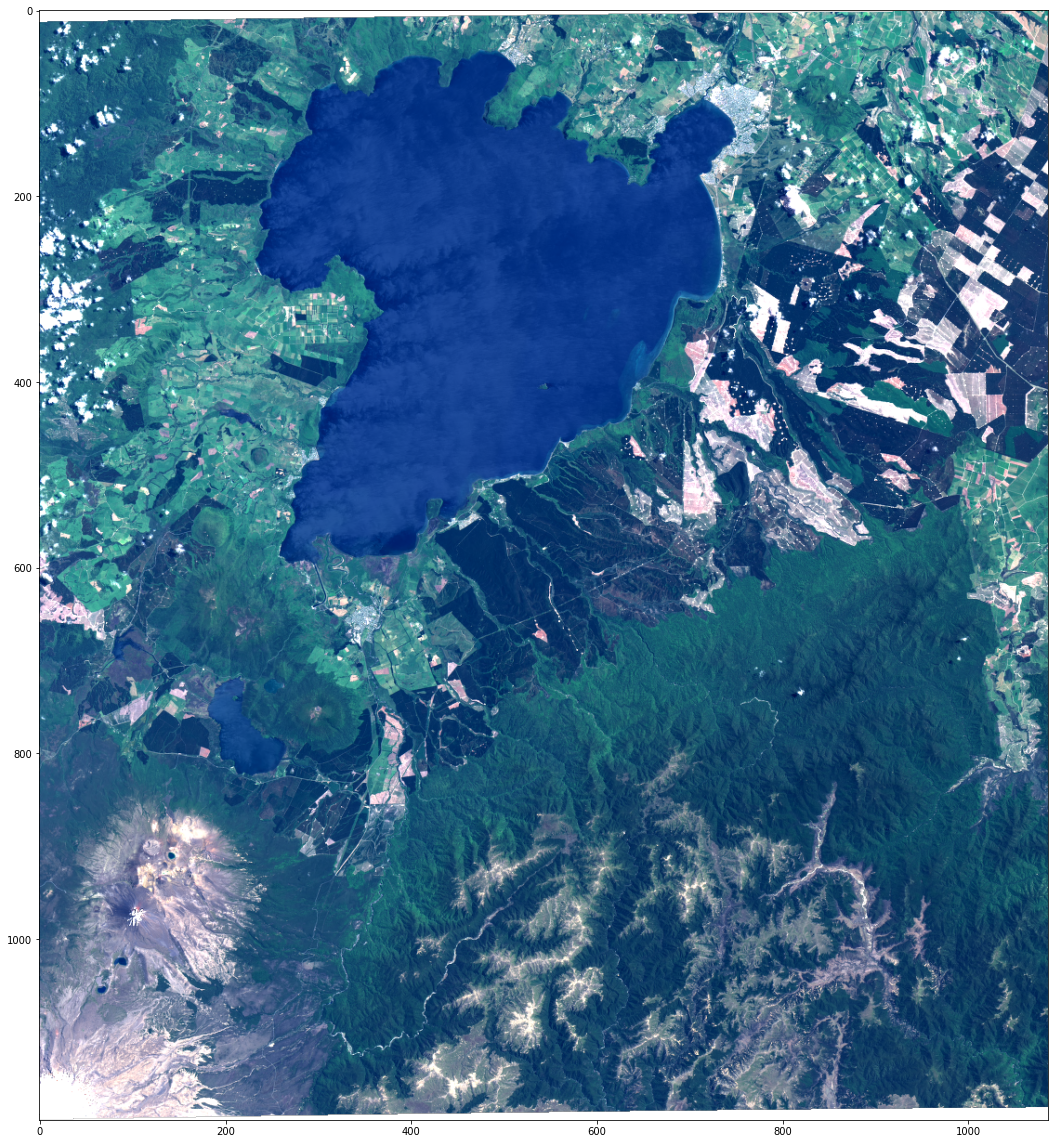

In [33]:
# Display the image data
dl.scenes.display(arr, size=16)

## Write helper functions to rasterize vector 
We need a library of functions to rasterize our training data.

In [9]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    print
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

## Load training data

The data used to train the classifier are individual shapefiles being read in from a file. 

In [21]:
train_data_path = "data/train/"

In [29]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
print("There are {} classes:".format(len(classes)))
for c in classes:
    print(c)
 
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = stacked[is_train]

There are 8 classes:
forest
snow
clear_cut
urban
grass
bare_ground
mature_plantation
water


## Train the classifier and run the land cover classification

In [ ]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

In [13]:
n_samples = rows*cols
flat_pixels = stacked.reshape((n_samples, bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

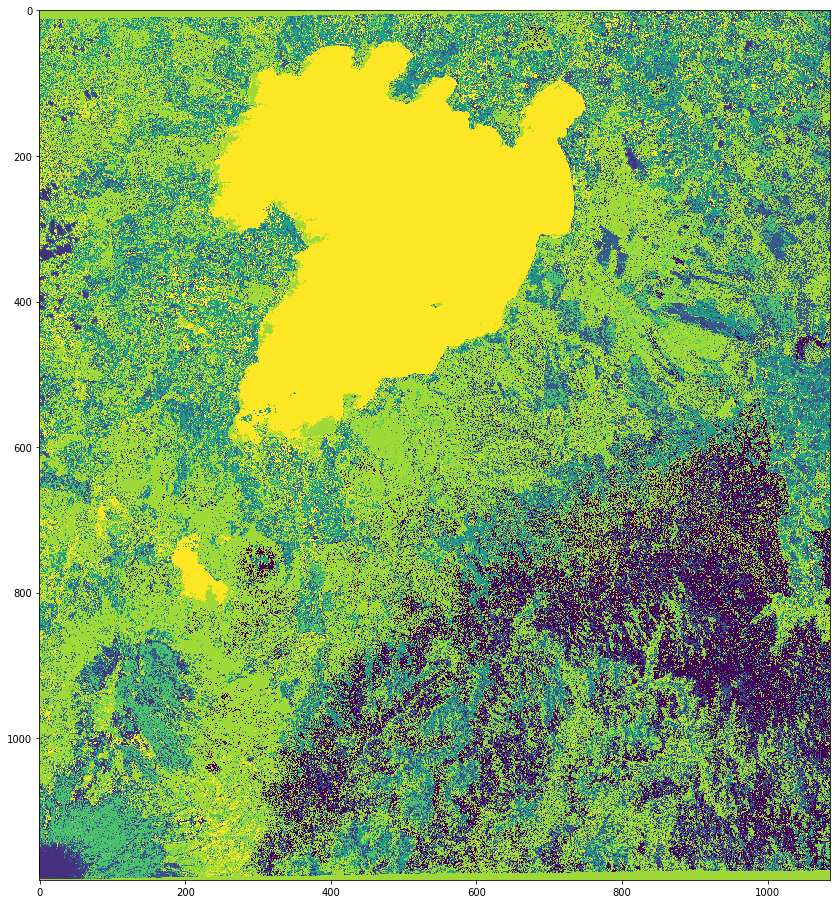

In [14]:
plt.figure(figsize=[16,16])
plt.imshow(classification)